In [1]:
%load_ext autoreload

%autoreload 2

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=UserWarning)

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pykep as pk

import deepxde as dde

from scipy.integrate import odeint
from icecream import ic
from mpl_toolkits.mplot3d import Axes3D
from numpy.linalg import norm

from astropy import units as u
import astropy
import ast

from poliastro.bodies import Earth, Mars, Sun
from poliastro.twobody import Orbit
from poliastro.twobody.propagation import cowell, propagate
from poliastro.maneuver import Maneuver
from poliastro.iod import izzo

Using backend: tensorflow.compat.v1



Instructions for updating:
non-resource variables are not supported in the long term



## Example Section 

In [6]:
norm([2.36208258e-09, 1.03685528e-09, 5.58554708e-10])/np.array([5.07958421e-10, 2.70324818e-10 ,4.95210606e-10])

array([4.65014947, 3.83559041, 1.12791346])

In [8]:
with open('../OrbitParams.npy', 'rb') as file:
    r0 = np.load(file)* u.m
    rf = np.load(file)/1000*u.km
    v0 = np.load(file)* u.m/u.s
    vf = np.load(file)* u.m/u.s

    v1 = np.load(file)* u.m/u.s
    v1_pred = np.load(file)* u.m/u.s

    TOF = np.load(file)[0]
    t1 = np.load(file)[0]

# convert mjd to jd
t1 = astropy.time.Time(t1+2400000.5, format='jd')


PyKEP_orb = Orbit.from_vectors(Sun, r0, v1, epoch = t1)
TFC_orb   = Orbit.from_vectors(Sun, r0, v1_pred, epoch = t1)

PyKEP_prop = PyKEP_orb.propagate(TOF*3600*24*u.second, method=cowell)
TFC_prop = TFC_orb.propagate(TOF*3600*24*u.second, method=cowell)

rf_pk = PyKEP_prop.r.to(u.km)
rf_model = TFC_prop.r.to(u.km)

print(rf.to(u.km))
print(rf_model.to(u.km), '\n')

pk_error = abs((rf_pk - rf)/rf)
model_error = abs((rf_model - rf)/rf)
print(pk_error)
print(model_error)

print('error difference:' , pk_error - model_error)
print('error difference in meters:' , norm(pk_error*rf))
print('error difference in meters:' , norm(model_error*rf), '\n')


r0_orb =Orbit.from_vectors(Sun, r0.to(u.meter), v0, epoch = t1)
rf_orb =Orbit.from_vectors(Sun, rf.to(u.meter), vf, epoch = t1 + TOF*u.day)
sol = Maneuver.lambert(r0_orb, rf_orb, short=True, M=0)
(vlam, v), = izzo.lambert(Sun.k, r0, rf, TOF*u.day)

print((vlam.to(u.m/u.s)))
print(v1)
print(v1_pred)

[-2.13628584e+08 -1.09446010e+08  2.95652201e+06] km
[-2.13628567e+08 -1.09446011e+08  2.95652188e+06] km 

[1.53949695e-07 3.77135759e-08 1.10546424e-07]
[7.59223147e-08 1.41476518e-08 4.24409240e-08]
error difference: [7.80273804e-08 2.35659241e-08 6.81055001e-08]
error difference in meters: 33.14767092684518 km
error difference in meters: 16.293403204348408 km 

[-31959.74944783   8565.69569662    289.74548649] m / s
[-31959.74918974   8565.69553493    289.74548472] m / s
[-31959.74930692   8565.69565152    289.74548905] m / s


In [9]:
from astropy import time
from astropy import units as u

import numpy as np
from poliastro.twobody.propagation import propagate, cowell
from poliastro.core.perturbations import J2_perturbation
from poliastro.core.propagation import func_twobody


def f(t0, state, k):
    du_kep = func_twobody(t0, state, k)
    ax, ay, az = J2_perturbation(
        t0, state, k, J2=Sun.J2.value, R=Sun.R.to(u.km).value
    )
    du_ad = np.array([0, 0, 0, ax, ay, az])

    return du_kep + du_ad

times = np.linspace(0, TOF*u.day, 500)

positions = propagate(
    TFC_orb,
    time.TimeDelta(times),
    method=cowell,
    rtol=1e-11,
    f=f
)

norm([positions[-1].x.value, positions[-1].y.value, positions[-1].z.value]*u.km - rf)

<Quantity 16.30091288 km>

In [36]:
import pandas as pd
import pickle

pd.set_option('display.max_rows', 20)
with open('Training_DF.pkl', 'rb') as file:
    df = pickle.load(file)

for i in range(8):
    display(df[i*20:(i+1)*20])


Index(['Loss', 'Training Time', 'Percent 1e-10', 'Percent 1e-12',
       'Percent 1e-13'],
      dtype='object')


Loss  \
Shortway basis_function method poly_order poly_remove                     
True     CP             lstsq  5          -1            32.600004432397   
                                           0            14.392141224825   
                                           1            15.449077429580   
                                           2             7.255254016778   
                               10         -1             0.420936002567   
                                           0             0.094368000454   
                                           1             0.471229546862   
                                           2             0.086562723210   
                               30         -1             0.000000514076   
                                           0             0.000001306876   
                                           1             0.000000092607   
                                           2             0.000004713599   
                               50         -1             0.000000000055   
                                           0            58.788377584658   
                                           1             0.000000000002   
                                           2             0.000000000054   
                               100        -1             0.000000000003   
                                           0           140.290093589755   
                                           1            67.881910470363   
                                           2            62.572821883704   

                                                       Training Time  \
Shortway basis_function method poly_order poly_remove                  
True     CP             lstsq  5          -1                3.165157   
                                           0                3.196495   
                                           1                3.112274   
                                           2                3.017587   
                               10         -1                3.135355   
                                           0                3.789791   
                                           1                3.071528   
                                           2                3.046767   
                               30         -1                3.135734   
                                           0                3.160650   
                                           1                3.171177   
                                           2                3.195716   
                               50         -1                3.220479   
                                           0                3.350913   
                                           1                5.001229   
                                           2                3.305642   
                               100        -1                3.592266   
                                           0                3.346178   
                                           1                3.267440   
                                           2                3.611221   

                                                       Percent 1e-10  \
Shortway basis_function method poly_order poly_remove                  
True     CP             lstsq  5          -1                     0.0   
                                           0                     0.0   
                                           1                     0.0   
                                           2                     0.0   
                               10         -1                     0.0   
                                           0                     0.0   
                                           1                     0.0   
                                           2                     0.0   
                               30         -1                    60.0   
                                       

Loss  \
Shortway basis_function method poly_order poly_remove                    
True     CP             pinv   5          -1            8.896855785139   
                                           0           14.537149833795   
                                           1           14.687659088496   
                                           2            9.452839651937   
                               10         -1            0.086299399302   
                                           0            0.262205209274   
                                           1            2.881064586077   
                                           2            0.638395410012   
                               30         -1            0.000002640179   
                                           0            0.000000304930   
                                           1            0.000028614337   
                                           2            0.000000455044   
                               50         -1            0.000000000002   
                                           0            0.000000000042   
                                           1            0.000000000002   
                                           2            0.000000000021   
                               100        -1            0.000000000017   
                                           0            0.000000000000   
                                           1            0.000000000000   
                                           2            0.000000000000   

                                                       Training Time  \
Shortway basis_function method poly_order poly_remove                  
True     CP             pinv   5          -1                3.695543   
                                           0                3.219615   
                                           1                3.478385   
                                           2                3.403952   
                               10         -1                3.749008   
                                           0                3.187986   
                                           1                3.216179   
                                           2                3.204353   
                               30         -1                3.298870   
                                           0                3.293012   
                                           1                3.372719   
                                           2                4.687373   
                               50         -1                3.428094   
                                           0                3.399318   
                                           1                3.542463   
                                           2                3.438307   
                               100        -1                5.999080   
                                           0                3.264449   
                                           1                5.832882   
                                           2                3.540381   

                                                       Percent 1e-10  \
Shortway basis_function method poly_order poly_remove                  
True     CP             pinv   5          -1                     0.0   
                                           0                     0.0   
                                           1                     0.0   
                                           2                     0.0   
                               10         -1                     0.0   
                                           0                     0.0   
                                           1                     0.0   
                                           2                     0.0   
                               30         -1                    20.0   
                                           0                

Loss  \
Shortway basis_function method poly_order poly_remove                     
True     ELMTanh        lstsq  5          -1             1.145792020878   
                                           0           128.748624729958   
                                           1            11.887664601791   
                                           2            43.597503737830   
                               10         -1             0.298097141339   
                                           0             5.600679953738   
                                           1             0.077774030980   
                                           2             0.419324384176   
                               30         -1             0.001533158959   
                                           0             0.000786843995   
                                           1             0.000181239321   
                                           2             0.000673810304   
                               50         -1            71.924558814347   
                                           0             0.000117762786   
                                           1             0.000012959229   
                                           2             0.000655431897   
                               100        -1             0.000373562813   
                                           0             0.000239687380   
                                           1             0.000039555323   
                                           2             0.000376633918   

                                                       Training Time  \
Shortway basis_function method poly_order poly_remove                  
True     ELMTanh        lstsq  5          -1                3.330088   
                                           0                3.331401   
                                           1                3.232966   
                                           2                3.147965   
                               10         -1                3.375383   
                                           0                4.163050   
                                           1                3.417695   
                                           2                3.334108   
                               30         -1                4.420990   
                                           0                4.143873   
                                           1                4.338372   
                                           2                4.110257   
                               50         -1                5.526173   
                                           0                5.463558   
                                           1                5.172729   
                                           2                5.547554   
                               100        -1                8.360000   
                                           0                8.975187   
                                           1                8.582167   
                                           2                8.572065   

                                                       Percent 1e-10  \
Shortway basis_function method poly_order poly_remove                  
True     ELMTanh        lstsq  5          -1                     0.0   
                                           0                     0.0   
                                           1                     0.0   
                                           2                     0.0   
                               10         -1                     0.0   
                                           0                     0.0   
                                           1                     0.0   
                                           2                     0.0   
                               30         -1                     0.0   
                                       

Loss  \
Shortway basis_function method poly_order poly_remove                     
True     ELMTanh        pinv   5          -1            11.551253470631   
                                           0            26.025984618154   
                                           1             9.303288389386   
                                           2           344.126502518576   
                               10         -1             0.046613150412   
                                           0             0.104667683177   
                                           1             0.093386394342   
                                           2             2.224890672798   
                               30         -1             0.001265637993   
                                           0             0.000628030988   
                                           1             0.008040689617   
                                           2             0.000680288227   
                               50         -1            71.743110113358   
                                           0             0.000066928690   
                                           1             0.000201907173   
                                           2             0.000036977790   
                               100        -1            65.794097003857   
                                           0             0.000157387667   
                                           1             0.000068922928   
                                           2             0.000006569701   

                                                       Training Time  \
Shortway basis_function method poly_order poly_remove                  
True     ELMTanh        pinv   5          -1                3.429768   
                                           0                3.591958   
                                           1                3.578578   
                                           2                3.224632   
                               10         -1                3.525301   
                                           0                3.522785   
                                           1                4.321044   
                                           2                3.355275   
                               30         -1                5.457616   
                                           0                6.024335   
                                           1                4.405578   
                                           2                4.396562   
                               50         -1                5.631866   
                                           0                5.708320   
                                           1                5.720522   
                                           2                5.638716   
                               100        -1                8.340520   
                                           0                8.527564   
                                           1                8.351000   
                                           2                9.040546   

                                                       Percent 1e-10  \
Shortway basis_function method poly_order poly_remove                  
True     ELMTanh        pinv   5          -1                     0.0   
                                           0                     0.0   
                                           1                     0.0   
                                           2                     0.0   
                               10         -1                     0.0   
                                           0                     0.0   
                                           1                     0.0   
                                           2                     0.0   
                               30         -1                     0.0   
                                       

Loss  \
Shortway basis_function method poly_order poly_remove                    
True     LeP            lstsq  5          -1           17.075627783143   
                                           0           32.238194947507   
                                           1           15.372692070573   
                                           2           86.134084625687   
                               10         -1            1.981950886172   
                                           0            2.576124230853   
                                           1            0.406651023986   
                                           2            1.870928137246   
                               30         -1            0.000001718654   
                                           0            0.000000199280   
                                           1            0.000001167730   
                                           2            0.000001830331   
                               50         -1            0.000000000426   
                                           0            0.000000000010   
                                           1            0.000000000000   
                                           2            0.000000000003   
                               100        -1            0.000000000000   
                                           0           56.315702672284   
                                           1            0.000000000002   
                                           2            0.000000000001   

                                                       Training Time  \
Shortway basis_function method poly_order poly_remove                  
True     LeP            lstsq  5          -1                3.128984   
                                           0                3.267312   
                                           1                3.076303   
                                           2                3.409902   
                               10         -1                3.644975   
                                           0                3.131089   
                                           1                3.080349   
                                           2                3.862096   
                               30         -1                3.144413   
                                           0                3.151939   
                                           1                3.178598   
                                           2                3.081798   
                               50         -1                4.851634   
                                           0                3.096488   
                                           1                3.292306   
                                           2                3.171053   
                               100        -1                3.337797   
                                           0                3.087635   
                                           1                3.233536   
                                           2                3.394061   

                                                       Percent 1e-10  \
Shortway basis_function method poly_order poly_remove                  
True     LeP            lstsq  5          -1                     0.0   
                                           0                     0.0   
                                           1                     0.0   
                                           2                     0.0   
                               10         -1                     0.0   
                                           0                     0.0   
                                           1                     0.0   
                                           2                     0.0   
                               30         -1                    40.0   
                                           0                

Loss  \
Shortway basis_function method poly_order poly_remove                    
True     LeP            pinv   5          -1            5.783128673824   
                                           0            9.614562364353   
                                           1           12.427526695472   
                                           2           16.035832190097   
                               10         -1            0.184696322017   
                                           0            0.393988745931   
                                           1            0.265950684387   
                                           2            0.014842385899   
                               30         -1            0.000000161228   
                                           0            0.000000000303   
                                           1            0.000001017231   
                                           2            0.000004926126   
                               50         -1           62.792189737044   
                                           0            0.000000000103   
                                           1            0.000000000001   
                                           2            0.000000000003   
                               100        -1           37.795183777820   
                                           0           70.098486233293   
                                           1            0.000000000002   
                                           2            0.000000000000   

                                                       Training Time  \
Shortway basis_function method poly_order poly_remove                  
True     LeP            pinv   5          -1                3.245269   
                                           0                3.141366   
                                           1                3.351667   
                                           2                3.072537   
                               10         -1                3.242046   
                                           0                3.191043   
                                           1                3.097555   
                                           2                3.081851   
                               30         -1                3.206250   
                                           0                3.258584   
                                           1                3.276895   
                                           2                3.231279   
                               50         -1                3.317334   
                                           0                3.331178   
                                           1                3.449252   
                                           2                3.274113   
                               100        -1                4.744897   
                                           0                3.741624   
                                           1                3.402289   
                                           2                3.385307   

                                                       Percent 1e-10  \
Shortway basis_function method poly_order poly_remove                  
True     LeP            pinv   5          -1                     0.0   
                                           0                     0.0   
                                           1                     0.0   
                                           2                     0.0   
                               10         -1                     0.0   
                                           0                     0.0   
                                           1                     0.0   
                                           2                     0.0   
                               30         -1                    20.0   
                                           0                

,,,,,Loss,Training Time,Percent 1e-10,Percent 1e-12,Percent 1e-13
Shortway,basis_function,method,poly_order,poly_remove,,,,,


,,,,,Loss,Training Time,Percent 1e-10,Percent 1e-12,Percent 1e-13
Shortway,basis_function,method,poly_order,poly_remove,,,,,


In [ ]:
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch

Documentation: https://deepxde.readthedocs.io/en/latest/demos/lorenz.inverse.html
"""

def gen_traindata():
    data = np.load("Lorenz.npz")
    return data["t"], data["y"]


C1 = dde.Variable(1.0)
C2 = dde.Variable(1.0)
C3 = dde.Variable(1.0)


def Lorenz_system(x, y):
    """Lorenz system.
    dy1/dx = 10 * (y2 - y1)
    dy2/dx = y1 * (15 - y3) - y2
    dy3/dx = y1 * y2 - 8/3 * y3
    """
    y1, y2, y3 = y[:, 0:1], y[:, 1:2], y[:, 2:]
    dy1_x = dde.grad.jacobian(y, x, i=0)
    dy2_x = dde.grad.jacobian(y, x, i=1)
    dy3_x = dde.grad.jacobian(y, x, i=2)
    return [
        dy1_x - C1 * (y2 - y1),
        dy2_x - y1 * (C2 - y3) + y2,
        dy3_x - y1 * y2 + C3 * y3,
    ]


def boundary(_, on_initial):
    return on_initial


geom = dde.geometry.TimeDomain(0, 3)

# Initial conditions
ic1 = dde.IC(geom, lambda X: -8, boundary, component=0)
ic2 = dde.IC(geom, lambda X: 7, boundary, component=1)
ic3 = dde.IC(geom, lambda X: 27, boundary, component=2)

# Get the train data
observe_t, ob_y = gen_traindata()
observe_y0 = dde.PointSetBC(observe_t, ob_y[:, 0:1], component=0)
observe_y1 = dde.PointSetBC(observe_t, ob_y[:, 1:2], component=1)
observe_y2 = dde.PointSetBC(observe_t, ob_y[:, 2:3], component=2)

data = dde.data.PDE(
    geom,
    Lorenz_system,
    [ic1, ic2, ic3, observe_y0, observe_y1, observe_y2],
    num_domain=400,
    num_boundary=2,
    anchors=observe_t,
)

net = dde.maps.FNN([1] + [40] * 3 + [3], "tanh", "Glorot uniform")
model = dde.Model(data, net)
model.compile("adam", lr=0.001, external_trainable_variables=[C1, C2, C3])
variable = dde.callbacks.VariableValue(
    [C1, C2, C3], period=600, filename="variables.dat"
)
losshistory, train_state = model.train(epochs=60000, callbacks=[variable])
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

In [ ]:
upred = model.predict(np.array(np.linspace(0,4,10001)).reshape(-1,1))
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.plot(upred[:,0],upred[:,1], upred[:,2])
ax.view_init(10,10)

In [ ]:
rho = 9.98
sigma = 15.0
beta = 2.67

def f(state, t):
    x, y, z = state  # Unpack the state vector
    return sigma * (y - x), x * (rho - z) - y, x * y - beta * z  # Derivatives

state0 = [-8, 7, 27]
t = np.arange(0.0, 100.0, 0.001)

states = odeint(f, state0, t)

fig = plt.figure()
ax = fig.gca(projection="3d")
ax.plot(states[:, 0], states[:, 1], states[:, 2])
ax.view_init(0,0)
plt.draw()
plt.show()

## 1D Gravity Trajectory Testing

In [2]:
def plot1D_grav(u0, v0, ub, ax=None): 
    x0 = u0
    vx0 = v0

    # mu = pk.MU_SUN/pk.AU**3 * deltat**2

    def f(state, t):
        # x, dx, y, dy = state  # Unpack the state vector
        x, dx, = state  # Unpack the state vector
        r = x #+pk.EARTH_RADIUS
        return dx, -pk.MU_SUN/(r**2) # Derivatives

    state0 = [x0, vx0]
    # state0 = [x0, vx0, y0, vy0]
    t = np.arange(0.0, ub+ub/500, ub/500)

    states = odeint(f, state0, t)   

    if ax==None:
        ic()
        fig = plt.figure(figsize=(5,5))
        ax = plt.gca()
    ax.plot(t, states[:, 0]*1.0, color='green', label = 'True', linewidth=5)
    ax.legend(fontsize = 40)
    ax.ticklabel_format(useOffset=False)
    # ax.view_init(0,0)

    return states

# ax.set_ylim([-1.5,1.5])
# ax.set_xlim([-1.5,1.5])

ic| 2182914392.py:20 in plot1D_grav() at 18:56:08.792
ic| mu*(_r/(nc))/((_r/nc)**2)**(3/2): 1.0000000000000002
ic| _deltat/tnc: 14.981818642619857
ic| mu: 1.0000000000000002


1.0000000000000002

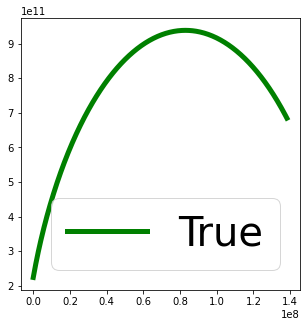

In [64]:
# _r0 = 1e08
# _deltat = 1000000
# v0 = 2500a

_r0 = 1.5*pk.AU
_deltat = 1600*24*3600
v0 = 30*1000

states = plot1D_grav(_r0, v0, _deltat)

_rf = states[-1,0]

nc = _r0
tnc = np.sqrt(nc**3/pk.MU_SUN)

# r0 = [_r0/nc,_r0/nc]
# rf = [_rf/nc, _rf/nc]
# mu = pk.MU_EARTH/(nc)**3 * tnc**2
# _r = _r0+pk.EARTH_RADIUS
# ic(mu*(_r/(nc))/((_r/nc)**2)**(3/2))
# ic(mu)

r0 = [_r0/nc]
rf = [_rf/nc,]   
mu = pk.MU_SUN/(nc)**3 * tnc**2
_r = _r0
ic(mu*(_r/(nc))/((_r/nc)**2)**(3/2))
ic(_deltat/tnc)
ic(mu)



In [65]:
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch

Documentation: https://deepxde.readthedocs.io/en/latest/demos/lorenz.inverse.html
"""

lb, ub = 0, _deltat/tnc

def gen_traindata():
    # tsample = np.linspace(0,4,100).reshape(-1,1)
    tsample = np.array(ub).reshape(-1,1)
    return tsample, np.hstack([rf[0]]).reshape(-1,1)
    # return tsample, np.hstack([np.sin(tsample), np.cos(tsample)])

def Lorenz_system(x, y):
    """Lorenz system.
    dy1/dx = 10 * (y2 - y1)
    dy2/dx = y1 * (15 - y3) - y2
    """ 
    y1, y2 = y[:, 0:1], y[:, 0:1]
    r = y1#+pk.EARTH_RADIUS/nc
    # r = y1+4.263519e-5
    dy1_xx = dde.grad.hessian(y, x)
    return dy1_xx + mu/(r**2)

np.random.seed()
tf.compat.v1.reset_default_graph()
n = np.random.randint(0,10000)
# n = 878
n = 7559
print(f'seed used: {n}')
dde.config.set_random_seed(n)


def boundary(_, on_initial):
    return on_initial


geom = dde.geometry.TimeDomain(lb, ub)

# Initial conditions
ic1 = dde.IC(geom, lambda X: r0[0], boundary)
# Get the train data
observe_t, ob_y = gen_traindata()
observe_y0 = dde.PointSetBC(observe_t, ob_y[:, 0:1], component=0)

data = dde.data.PDE(
    geom,
    Lorenz_system,
    [ic1, observe_y0],
    num_domain=200,
    num_boundary=20,
    anchors=observe_t,
)

net = dde.maps.FNN([1] + [50] * 3 + [1], "sigmoid", "Glorot uniform")
net.apply_output_transform(
    lambda x, y: (ub-x)/ub*r0 + (x/ub)*rf + x/ub*(ub-x)/ub*y
)
model = dde.Model(data, net)


# lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([3000.0, 5000.0, 10000.0 ],[1e-2, 5e-3, 1e-3, 1e-4])
# lr = 0.1
# decay weigth = 0.5 : decrease by 50% every 2000 steps
model.compile("adam", lr=0.01, 
            decay = ("inverse time", 10000, 0.5)
)

losshistory, train_state = model.train(epochs=300, display_every=1000)


# dde.config.set_default_float("float32") #If L-BFGS stops earlier than expected, set the default float type to ‘float64’:If L-BFGS stops earlier than expected, set the default float type to ‘float64’:
model.compile("L-BFGS-B")
dde.optimizers.config.set_LBFGS_options(maxcor=100, ftol=0, gtol=1e-10, maxiter=15000, maxfun=None, maxls=50)
losshistory, train_state = model.train(display_every=1000)

GradCallback = dde.callbacks.FirstDerivative(0)

seed used: 7559
Compiling model...
Building feed-forward neural network...
'build' took 0.058340 s

'compile' took 0.840909 s

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric
0         [1.63e-01, 0.00e+00, 0.00e+00]    [1.63e-01, 0.00e+00, 0.00e+00]    []  
300       [1.32e-04, 0.00e+00, 0.00e+00]    [1.32e-04, 0.00e+00, 0.00e+00]    []  

Best model at step 300:
  train loss: 1.32e-04
  test loss: 1.32e-04
  test metric: []

'train' took 0.914201 s

Compiling model...
'compile' took 0.412328 s

Training model...

Step      Train loss                        Test loss                         Test metric
300       [1.32e-04, 0.00e+00, 0.00e+00]    [1.32e-04, 0.00e+00, 0.00e+00]    []  
INFO:tensorflow:Optimization terminated with:
  Message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  Objective function value: 0.000000
  Number of iterations: 277
  Number of functions evaluations: 347
647       [

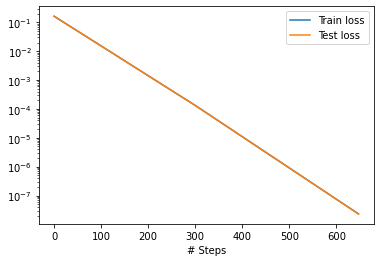

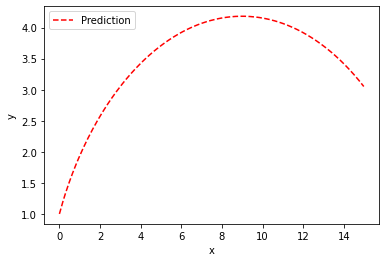

V0 Desired: 30000 m/s 
V0 Predicted: [[29999.732]] m/s 
Error : [[-0.00089264]] %
Intial Accuracy 
	 Predicted:[1.] 
	 Desired: 1.0 
	 % Error: [0.]
Final Accuracy 
	 Predicted:[3.0512578] 
	 Desired: 3.0512578410925886 
	 % Error: [0.]


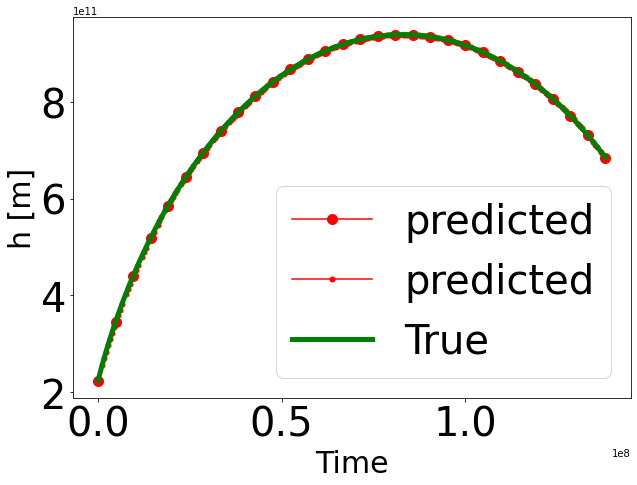

In [66]:
import matplotlib.pyplot as plt

plot_trajec = 0
ax = dde.saveplot(losshistory, train_state, issave=False, isplot=True)
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)

tsample = np.linspace(lb, ub ,30).reshape(-1,1)
upred = model.predict(tsample)[:,plot_trajec]*nc
ax.plot((tsample*tnc), upred, label = 'predicted',color='red', marker='o', markersize=10)
ax.ticklabel_format(useOffset=False)


X_train, y_train = train_state.X_train, train_state.y_train
X_test, y_test, best_y, best_ystd = train_state.X_test, train_state.y_test, train_state.best_y, train_state.best_ystd
idx = np.argsort(X_test[:, 0])  
X = X_test[idx, 0]
best_y = best_y[idx]
plt.plot(X*tnc, best_y*nc,  label = 'predicted', color='red', marker='o', markersize=5)

ax.set_xlabel('Time', fontsize=30)
ax.set_ylabel('h [m]', fontsize=30)
ax.tick_params(labelsize=40)
ax.legend(fontsize=40)

# ax.set_ylim([-2,2]
# ax.set_xlim([-2,2])
def dydx(x, y):
    return dde.grad.jacobian(y, x, i=plot_trajec, j=0)
dy_dx = model.predict(np.array([[0]]), operator=dydx)

print(f"V0 Desired: {v0} m/s \nV0 Predicted: {dy_dx*nc/tnc} m/s \nError : {100 - v0/(dy_dx*nc/tnc)*100} %")

print(f'Intial Accuracy \n\t Predicted:{best_y[0]} \n\t Desired: {r0[0]} \n\t % Error: {100 - best_y[0]/r0[0]*100}')
print(f'Final Accuracy \n\t Predicted:{best_y[-1]} \n\t Desired: {rf[0]} \n\t % Error: {100 - best_y[-1]/rf[0]*100}')

TrueStates = plot1D_grav(r0[plot_trajec]*nc, v0, ub*tnc, ax=ax)

# ax.view_init(90,0)
# plt.show()

# ax = pk.orbit_plots.plot_lambert(lamsol_list, N=60, sol=0, units=pk.AU, legend=False, axes=None, alpha=1.)  
# ax.view_init(90,0)

In [6]:
def props(cls):   
  return [i for i in cls.__dict__.keys()]
  
properties = props(train_state)

## 3D Gravity Trajectory Testing

In [108]:
def plot3D_grav(u0, v0, ub, uf=[None,None,None], mode='SUN', ax=None): 
    x0, y0, z0 = u0
    vx0, vy0, vz0 = v0
    fontsize = 30

    # mu = pk.MU_SUN/pk.AU**3 * deltat**2
    if mode=='SUN':
        def f(state, t):
            # x, dx, y, dy = state  # Unpack the state vector
            x, dx, y, dy, z, dz = state  # Unpack the state vector
            rx = x
            ry = y
            rz = z
            return dx, -pk.MU_SUN*rx/(rx**2 + ry**2 + rz**2)**(3/2), \
                   dy, -pk.MU_SUN*ry/(rx**2 + ry**2 + rz**2)**(3/2), \
                   dz, -pk.MU_SUN*rz/(rx**2 + ry**2 + rz**2)**(3/2) # Derivatives
            
    elif mode=='EARTH':
        def f(state, t):
            # x, dx, y, dy = state  # Unpack the state vector
            x, dx, y, dy = state  # Unpack the state vector
            rx = x + pk.EARTH_RADIUS
            ry = y + pk.EARTH_RADIUS
            return dx, -pk.MU_EARTH*rx/(rx**2 + ry**2)**(3/2), dy, -pk.MU_EARTH*ry/(rx**2 + ry**2)**(3/2) # Derivatives

    #state0 = [u0, 0]
    state0 = [x0, vx0, y0, vy0, z0, vz0]
    t = np.arange(0.0, ub+ub/50000, ub/50000)

    states = odeint(f, state0, t)

    if ax==None:
        # ic()
        fig = plt.figure(figsize=(10,5))
        ax = plt.gca()

    ax.ticklabel_format(useOffset=False)
    ax.plot(states[:, 0]/1000, states[:, 2]/1000, color='green', label = 'True', linewidth=2)
    ax.plot(states[0, 0]/1000, states[0, 2]/1000, color='blue', label = 'Initial Position', marker='o', markersize=10)
    # ax.plot(states[-1, 0], states[-1, 2], color='red', label = 'Final Position', marker='o', markersize=10)
    if all(uf):
        ax.plot([0, states[0,0]/1000], [0, states[0,2]/1000], '-r')
        ax.plot([0, uf[0]/1000], [0, uf[1]/1000], '-r')
        ax.plot(uf[0]/1000, uf[1]/1000, color='orange', label = 'Lambert Position', marker='o', markersize=10)

    ax.legend(fontsize = fontsize)
    ax.xaxis.offsetText.set_fontsize(fontsize)
    ax.yaxis.offsetText.set_fontsize(fontsize)
    plt.xticks(fontsize= fontsize)
    plt.yticks(fontsize= fontsize)

    plt.show()
    # ic(states[-1,:])
    # ax.view_init(0,0)

    return states

In [14]:
class LambertEq():
    def __init__(self, callback_config):
        # Reset workspace 
        np.random.seed()
        tf.compat.v1.reset_default_graph()
        self.callback_config = callback_config
    class color:
        PURPLE = '\033[95m'
        CYAN = '\033[96m'
        DARKCYAN = '\033[36m'
        BLUE = '\033[94m'
        GREEN = '\033[92m'
        YELLOW = '\033[93m'
        RED = '\033[91m'
        BOLD = '\033[1m'
        UNDERLINE = '\033[4m'
        RESET = '\033[0m'

In [81]:
class LambertEq(LambertEq):
    def Get_Lambert(self, new=True, shortway=True, defined=False):
        
        ############################################################################
        ########################## Define Lambert Problem ##########################
        ############################################################################

        if new and defined:
            # Set limits on TOF and starting date
            Start_Epoch     = int(pk.epoch_from_string("2001-01-01 00:00:00").mjd)
            End_Epoch       = int(pk.epoch_from_string("2001-09-01 00:00:00").mjd)
            
            # specify target planet
            _target = 'mars'
            
            self.t1 = np.array([Start_Epoch])
            self.t2 = End_Epoch
            self._TOF = self.t2-self.t1

        else:

            # Set limits on TOF and starting date
            Start_Epoch     = int(pk.epoch_from_string("2001-01-01 00:00:00").mjd)
            End_Epoch       = int(pk.epoch_from_string("2031-01-01 00:00:00").mjd)
            TOF_range       = [10, 300]
            
            # specify target planet
            _target = 'mars'

            # only generate new problem if required
            if new:
                self.t1              = np.random.randint(low=Start_Epoch, high=End_Epoch, size=1)
                self._TOF             = np.random.randint(low=TOF_range[0], high=TOF_range[1], size=1)
                self.t2              = self.t1 + self._TOF

        # Get Ephemeris data from pykep
        Departure       = pk.planet.jpl_lp('earth') 
        Target          = pk.planet.jpl_lp(_target)

        States0         = Departure.eph(pk.epoch(int(self.t1), 'mjd'))
        Statesf         = Target.eph(pk.epoch(int(self.t2), 'mjd'))

        self._r0              = np.array(States0[0])
        self._rf              = np.array(Statesf[0])

        if shortway:
            clockwise = True if np.cross(self._r0,self._rf)[2] < 0 else False
        else:
            clockwise = True if np.cross(self._r0,self._rf)[2] >= 0 else False


        ################################################################################
        ############################# Solve Lambert Problem ############################
        ################################################################################

        lamsol_list = pk.lambert_problem(r1=self._r0, r2=self._rf, tof=int(self._TOF)*24*3600,
                                        mu=pk.MU_SUN, cw=clockwise)
        self.v1 = lamsol_list.get_v1()[0]
        v2 = lamsol_list.get_v2()[0]
                            
        self.TOF = self.t2-self.t1
        ################################################################################
        ############################# Set up training data #############################
        ################################################################################


        # Define normamlising constants for distance and time
        self.nc = np.linalg.norm(self._r0)
        self.tnc = np.sqrt(self.nc**3/pk.MU_SUN)

        # Normalise input data
        self.r0 = self._r0/self.nc
        self.rf = self._rf/self.nc
        self.mu = pk.MU_SUN/(self.nc)**3 * self.tnc**2

        # Specifiy short or long way solution (dtheta<180?)
        self.short_way=shortway
        ic(self.TOF*24*3600/tnc)

        ################################################################################
        ############################# Ensure solution exists ###########################
        ################################################################################


        c = norm(self._r0 - self._rf)
        s = (norm(self._r0) +  norm(self._rf) + c) /2

        alpha_m = np.pi
        beta_m = 2*np.arcsin(np.sqrt((s-c)/s))

        # Minimum Energy Solution - determines long or short time solution 
        dt_m = np.sqrt(s**3/(8*pk.MU_SUN))*(np.pi - beta_m + np.sin(beta_m))     
        dtheta = np.arccos(np.dot(self._r0,self._rf)/(norm(self._r0)*norm(self._rf)))

        # if long way specified, adjust change in true anomaly for parabolic transfer time calculation
        if not self.short_way:
            print('Adjusting for long way solution')
            dtheta = 2*np.pi - dtheta
        # parabolic transfer time - minimum 
        dt_p = np.sqrt(2)/3*(s**1.5 - np.sign(np.sin(dtheta))*(s-c)**1.5)/np.sqrt(pk.MU_SUN)

        # Determine if desired solution corresponds to short or long time solution
        if self.TOF[0] < dt_m/3600/24 :
            self.short_time = True
        else:
            self.short_time = False
            
        # If desired solution non existent generate new solution with identical parameters
        if self.TOF[0] < dt_p/3600/24:
            print('invlaid TOF, generating new problem')
            self.Get_Lambert(shortway = self.short_way)

            # Avoids double execution of function
            return 0
        ############################################################################
        ############################# Get Correct SMA ##############################
        ############################################################################

        if new:
            print(self.color.BOLD + self.color.GREEN + 
                f'Start Date: {pk.epoch(int(self.t1), "mjd")}')
            print(f'End Date:   {pk.epoch(int(self.t2), "mjd")}\n' + self.color.RESET)

            print(f'Min E deltaT: {dt_m/3600/24:.3f} days')
            print(f'parabolic deltaT: {dt_p/3600/24:.3f} days')
            print(f'Desired TOF:  {self.TOF[0]} days\n')

        
        
        _ = plot3D_grav(self._r0, self.v1, self.TOF*24*3600, self._rf)

        ############################################################################
        ############################ Fill in Config Dict ###########################
        ############################################################################
        self.callback_config['Lambert Problem']['Start Date'] = pk.epoch(int(self.t1), "mjd")
        self.callback_config['Lambert Problem']['End Date'] = pk.epoch(int(self.t2), "mjd")
        self.callback_config['Lambert Problem']['TOF'] = self.TOF[0]


In [89]:
class LambertEq(LambertEq):
    def TrainModel(self):

        ############################################################################
        ############################# Set Seed for reproducibility #################
        ############################################################################
        
        np.random.seed()
        tf.compat.v1.reset_default_graph()
        n = np.random.randint(0,10000)
        n = 878
        callback_config['seed'] = n
        print(f'seed used: {n}')
        dde.config.set_random_seed(n)

        ############################################################################
        ############################# Set up Model config options ##################
        ############################################################################
        self._deltat = self.TOF*24*3600
        self.lb, self.ub = 0, self._deltat/self.tnc

        def gen_traindata():
            tsample = np.array(self.ub).reshape(-1,1)
            return tsample, np.hstack(  [self.rf[0], self.rf[1], self.rf[2]]  ).reshape(-1,3)

        def ODE_system(x, y):

            rx, ry, rz = y[:, 0], y[:, 1], y[:,2]
            dy1_xx = dde.grad.hessian(y, x, component=0)
            dy2_xx = dde.grad.hessian(y, x, component=1)
            dy3_xx = dde.grad.hessian(y, x, component=2)

            return [
                dy1_xx + self.mu*rx/((rx**2) + (ry**2) + (rz**2))**(3/2),
                dy2_xx + self.mu*ry/((rx**2) + (ry**2) + (rz**2))**(3/2),
                dy3_xx + self.mu*rz/((rx**2) + (ry**2) + (rz**2))**(3/2),
            ]

        def boundary(_, on_initial):
            return on_initial

        geom = dde.geometry.TimeDomain(self.lb, self.ub)

        # Initial conditions
        ic1 = dde.IC(geom, lambda X: self.r0[0], boundary, component=0)
        ic2 = dde.IC(geom, lambda X: self.r0[1], boundary, component=1)
        ic3 = dde.IC(geom, lambda X: self.r0[2], boundary, component=2)
        # ic3 = dde.IC(geom, lambda X: r0[2], boundary, component=2)

        # Get the train data
        observe_t, ob_y = gen_traindata()
        observe_y0 = dde.PointSetBC(observe_t, ob_y[:, 0:1], component=0)
        observe_y1 = dde.PointSetBC(observe_t, ob_y[:, 1:2], component=1)
        observe_y2 = dde.PointSetBC(observe_t, ob_y[:, 2:3], component=2)
        # observe_y2 = dde.PointSetBC(observe_t, ob_y[:, 2:3], component=2)

        data = dde.data.PDE(
            geom,
            ODE_system,
            [ic1, ic2, ic3, observe_y0, observe_y1, observe_y2],
            num_domain=200,
            num_boundary=2,
            anchors=observe_t,
        )

        layers = callback_config['Model Architecture']['Layers']
        neurons =   callback_config['Model Architecture']['Neurons p Layer']
        net = dde.maps.FNN([1] + [neurons] * layers + [3], "tanh", "Glorot uniform")

        net.apply_output_transform(
        lambda x, y: (self.ub-x)/self.ub*self.r0 + (x/self.ub)*self.rf + x/self.ub*(self.ub-x)/self.ub*y*1e-3
        )

        self.model = dde.Model(data, net)

        ############################################################################
        ################################# Train Model ##############################
        ############################################################################
        
        # decay weigth = 0.5 : decrease by 50% every 2000 steps
        self.model.compile("adam", lr=callback_config['lr'], 
                    decay = ("inverse time", 
                              callback_config['Reduce lr']["steps"], 
                              callback_config['Reduce lr']["factor"]),
                              loss_weights = [1, 1, 1,  1, 1, 1,  1, 1, 1]
        )
        self.losshistory, self.train_state = self.model.train(epochs=callback_config['Adam Epochs'], display_every=100)

        # dde.config.set_default_float("float64") #If L-BFGS stops earlier than expected, set the default float type to ‘float64’:If L-BFGS stops earlier than expected, set the default float type to ‘float64’:
        self.model.compile("L-BFGS-B")
        dde.optimizers.config.set_LBFGS_options(maxcor=100, ftol=0, gtol=1e-10, maxiter=15000, maxfun=None, maxls=50)
        self.losshistory, self.train_state = self.model.train(display_every=100)

In [46]:
class LambertEq(LambertEq):
    def Get_Error(self):
        tsample = np.linspace(self.lb, self.ub ,30).reshape(-1,1)
        upred = self.model.predict(tsample)*self.nc
        ic(upred[0,:])
        ic(upred[-1,:])

        print(f'Intial X Accuracy \n\t Predicted:{upred[0,0]/self.nc} \n\t Desired: {self.r0[0]} \n\t % Error: {100 - upred[0,0]/self.nc/self.r0[0]*100}')
        print(f'Intial Y Accuracy \n\t Predicted:{upred[0,1]/self.nc} \n\t Desired: {self.r0[1]} \n\t % Error: {100 - upred[0,1]/self.nc/self.r0[1]*100}')
        print(f'Intial Z Accuracy \n\t Predicted:{upred[0,2]/self.nc} \n\t Desired: {self.r0[2]} \n\t % Error: {100 - upred[0,2]/self.nc/self.r0[2]*100}')

        print(f'Final X Accuracy \n\t Predicted:{upred[-1,0]/self.nc} \n\t Desired: {self.rf[0]} \n\t % Error: {100 - upred[-1,0]/self.nc/self.rf[0]*100}')
        print(f'Final Y Accuracy \n\t Predicted:{upred[-1,1]/self.nc} \n\t Desired: {self.rf[1]} \n\t % Error: {100 - upred[-1,1]/self.nc/self.rf[1]*100}')
        print(f'Final Z Accuracy \n\t Predicted:{upred[-1,2]/self.nc} \n\t Desired: {self.rf[2]} \n\t % Error: {100 - upred[-1,2]/self.nc/self.rf[2]*100}')

        import matplotlib.pyplot as plt

        ax = dde.saveplot(self.losshistory, self.train_state, issave=False, isplot=True)
        fig = plt.figure(figsize=(30,20))
        ax = fig.add_subplot(111)

        ## Last Model
        ax.plot(upred[:,0]/1000, upred[:,1]/1000, label = 'predicted',color='red', marker='o', markersize=10) 
        ax.ticklabel_format(useOffset=False)

        ## Best Model

        X_train, y_train = self.train_state.X_train, self.train_state.y_train
        X_test, y_test, best_y, best_ystd = self.train_state.X_test, self.train_state.y_test, self.train_state.best_y, self.train_state.best_ystd
        idx = np.argsort(X_test[:, 0])
        X = X_test[idx, 0]
        Pred_x = best_y[idx, 0]
        Pred_y = best_y[idx, 1]
        # ic(Pred_y)
        plt.plot(Pred_x*self.nc/1000, Pred_y*self.nc/1000, "--r", label = 'predicted',color='red', marker='o', markersize=5)

        ## Correct Solution
        ax.set_xlabel('X [m]', fontsize=30)
        ax.set_ylabel('Y [m]', fontsize=30)
        ax.tick_params(labelsize=40)
        ax.legend(fontsize=40)

        # ax.set_ylim([-2,2]
        # ax.set_xlim([-2,2])

        def dydx1(x, y):
            return dde.grad.jacobian(y, x, i=0, j=0)

        def dydx2(x, y):
            return dde.grad.jacobian(y, x, i=1, j=0)

        def dydx3(x, y):
            return dde.grad.jacobian(y, x, i=2, j=0)
        

        self.dy_dx1 = self.model.predict(np.array([[0]]), operator=dydx1)[0][0]
        self.dy_dx2 = self.model.predict(np.array([[0]]), operator=dydx2)[0][0]
        self.dy_dx3 = self.model.predict(np.array([[0]]), operator=dydx3)[0][0]

        error = (np.array([self.dy_dx1, self.dy_dx2, self.dy_dx3]) - self.v1/self.nc*self.tnc) / (self.v1/self.nc*self.tnc)

        print(f'predicted velocity: {self.dy_dx1, self.dy_dx2, self.dy_dx3}. \nDesired Velocity:{self.v1/self.nc*self.tnc}\n')
        print(f'% Error: {error*100}')

        def dydxx1(x, y):
            return dde.grad.hessian(y, x, component=0)

        

        dy_dxx = self.model.predict(np.array([[0]]), operator=dydxx1)
        ic(mu*r0[0]/((self.r0[0]**2) + (self.r0[1]**2) + self.r0[2]**2)**(3/2) , dy_dxx)

        # ic(best_y.shape)

        TrueStates =plot3D_grav(self._r0, self.v1, self.TOF*24*3600, self._rf, ax=ax)

        # ax.view_init(90,0)
        # plt.show()

        # ax = pk.orbit_plots.plot_lambert(lamsol_list, N=60, sol=0, units=pk.AU, legend=False, axes=None, alpha=1.)  
        # ax.view_init(90,0)

In [90]:
tf.keras.backend.clear_session()

callback_config = {}
callback_config['seed'] = {}
callback_config['Lambert Problem'] = {}
callback_config['Reduce lr'] = {}
callback_config['Model Architecture'] = {}

callback_config['lr'] = 0.01
callback_config['Adam Epochs'] = 100

callback_config['Reduce lr']["factor"] = 0.5
callback_config['Reduce lr']["steps"] = 10000



callback_config['Lambert Problem']['Start Date'] = {}
callback_config['Lambert Problem']['End Date'] = {}
callback_config['Lambert Problem']['TOF'] = {}

callback_config['Model Architecture']['Layers'] = 15
callback_config['Model Architecture']['Neurons p Layer'] = 100




ic| self.TOF*24*3600/tnc: array([4.28702178])


Start Date: 2001-Jan-01 00:00:00
End Date:   2001-Sep-01 00:00:00

Min E deltaT: 230.845 days
parabolic deltaT: 97.860 days
Desired TOF:  243 days



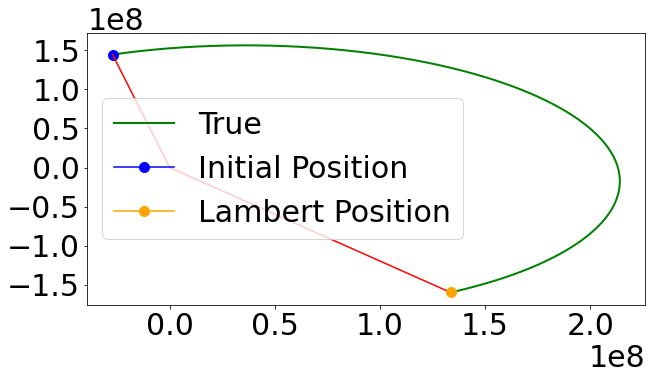

seed used: 878
Compiling model...
Building feed-forward neural network...
'build' took 0.653006 s

'compile' took 6.875979 s

Initializing variables...
Training model...

Step      Train loss                                                                                    Test loss                                                                                     Test metric
0         [1.55e+01, 8.79e+00, 7.29e-02, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00]    [1.55e+01, 8.79e+00, 7.29e-02, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00]    []  
100       [1.08e+01, 6.40e+00, 2.25e-01, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00]    [1.08e+01, 6.40e+00, 2.25e-01, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00]    []  

Best model at step 100:
  train loss: 1.74e+01
  test loss: 1.74e+01
  test metric: []

'train' took 29.129228 s

Compiling model...
'compile' took 4.668705 s

Training model...

Step      Train loss             

ic| upred[0,:]: array([-2.7130941e+10,  1.4457669e+11, -3.6554462e+05], dtype=float32)
ic| upred[-1,:]: array([ 1.3359619e+11, -1.5991529e+11, -6.6331341e+09], dtype=float32)


Intial X Accuracy 
	 Predicted:-0.1844383411039744 
	 Desired: -0.1844383379678393 
	 % Error: -1.700370518165073e-06
Intial Y Accuracy 
	 Predicted:0.982844083573918 
	 Desired: 0.9828440870664511 
	 % Error: 3.5534965547867614e-07
Intial Z Accuracy 
	 Predicted:-2.4850020182150526e-06 
	 Desired: -2.4850018265777607e-06 
	 % Error: -7.711756595085717e-06
Final X Accuracy 
	 Predicted:0.9081977573991882 
	 Desired: 0.9081977801362461 
	 % Error: 2.5035359385583433e-06
Final Y Accuracy 
	 Predicted:-1.0871171477973585 
	 Desired: -1.0871170945337214 
	 % Error: -4.899530821944609e-06
Final Z Accuracy 
	 Predicted:-0.04509258363706222 
	 Desired: -0.045092582179303294 
	 % Error: -3.232813156728298e-06


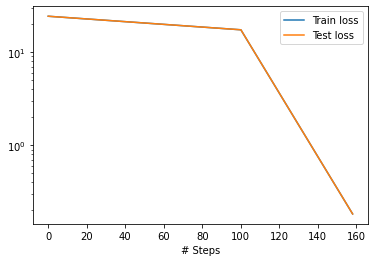

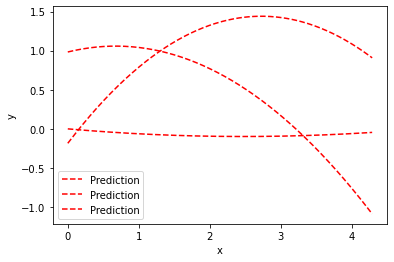

predicted velocity: (1.1910906, 0.22206226, -0.07894519). 
Desired Velocity:[ 1.00260662  0.38822018 -0.06887169]

% Error: [ 18.79939401 -42.79991868  14.62647843]


ic| mu*r0[0]/((self.r0[0]**2) + (self.r0[1]**2) + self.r0[2]**2)**(3/2): -0.18443829362151762
    dy_dxx: array([[-0.43676966]], dtype=float32)


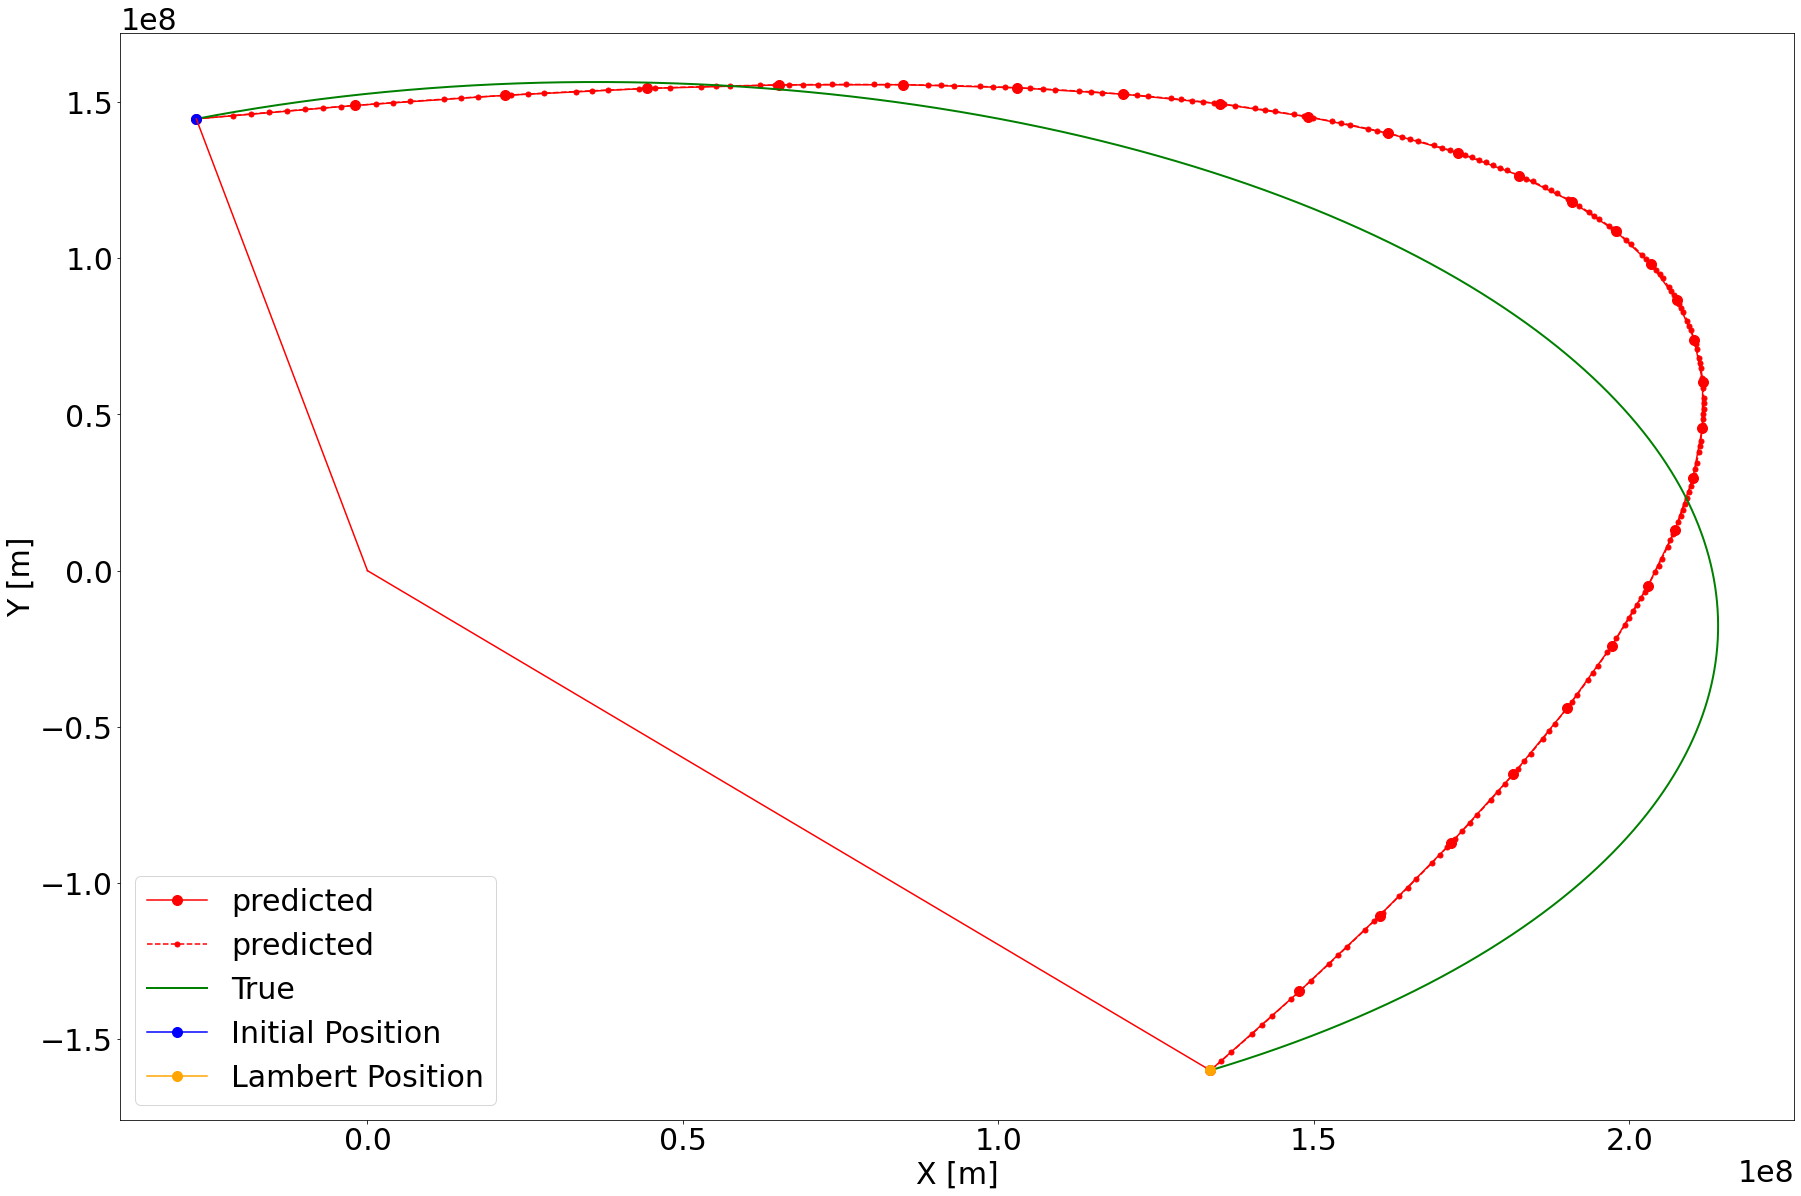

In [91]:
l = LambertEq(callback_config)
l.Get_Lambert(shortway=True, defined=True)
l.TrainModel()
l.Get_Error()

# Non Class IMplementation

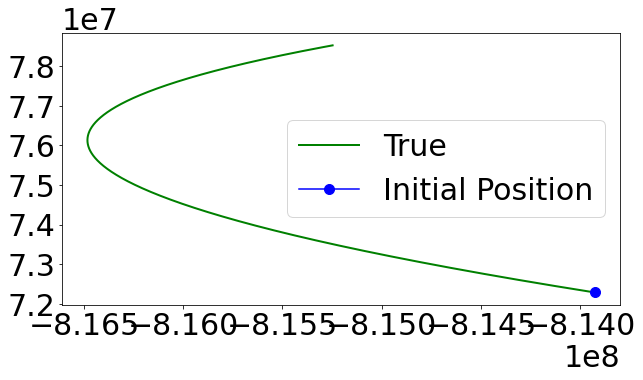

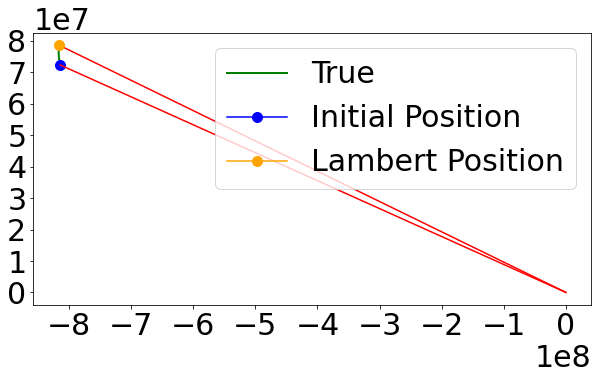

ic| rf: [-0.9976946869144877, 0.09610292576515254]
ic| mu*(_r[0]/(nc))/((_r[0]/nc)**2 +(_r[1]/nc)**2)**(3/2): -0.9960792012755969
ic| mu*(_r[1]/(nc))/((_r[0]/nc)**2 + (_r[1]/nc)**2)**(3/2): 0.08846595269463528
ic| _deltat/tnc: 0.1347509074482608


0.1347509074482608

In [212]:
_r0 = [-30*0.181359*pk.AU, 0.5*0.966435*pk.AU, 0]
_deltat = 100*24*3600
# v0 = [30114, 11660, 0]
v0 = [-1004, 800, 0]   

# _r0 = [pk.AU, 0]
# _deltat = 100*24*3600
# v0 = [20000, 20000]

states = plot3D_grav(_r0, v0, _deltat, mode='SUN')
_rf = states[-1,[0,2]]
states = plot3D_grav(_r0, v0, _deltat, mode='SUN', uf=_rf)
    

nc = norm(_r0)
tnc = np.sqrt(nc**3/pk.MU_SUN)
# tnc = _deltat

r0 = [_r0[0]/nc,_r0[1]/nc]
rf = [_rf[0]/nc, _rf[1]/nc]
ic(rf)

# mu = pk.MU_EARTH/(nc)**3 * tnc**2
# _r = _r0[0] + pk.EARTH_RADIUS, _r0[1] + pk.EARTH_RADIUS
# ic(mu*(_r[0]/(nc))/((_r[0]/nc)**2 + (_r[1]/nc)**2)**(3/2))
# ic(mu*(_r[1]/(nc))/((_r[0]/nc)**2 + (_r[1]/nc)**2)**(3/2))
# ic(mu)

mu = pk.MU_SUN/(nc)**3 * tnc**2
_r = _r0
ic(mu*(_r[0]/(nc))/((_r[0]/nc)**2 +(_r[1]/nc)**2)**(3/2))
ic(mu*(_r[1]/(nc))/((_r[0]/nc)**2 + (_r[1]/nc)**2)**(3/2))
ic(_deltat/tnc)

In [205]:
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch

Documentation: https://deepxde.readthedocs.io/en/latest/demos/lorenz.inverse.html
"""

lb, ub = 0, _deltat/tnc

def gen_traindata():
    # tsample = np.linspace(0,4,100).reshape(-1,1)
    tsample = np.array(ub).reshape(-1,1)
    return tsample, np.hstack(  [rf[0], rf[1]]  ).reshape(-1,2)
    # return tsample, np.hstack([np.sin(tsample), np.cos(tsample)])

def Lorenz_system(x, y):
    """Lorenz system.
    dy1/dx = 10 * (y2 - y1)
    dy2/dx = y1 * (15 - y3) - y2
    """ 
    rx, ry = y[:, 0], y[:, 1]
    # r = y1+pk.EARTH_RADIUS/nc

    dy1_xx = dde.grad.hessian(y, x, component=0)
    dy2_xx = dde.grad.hessian(y, x, component=1)

    return [
        dy1_xx + mu*rx/((rx**2) + (ry**2))**(3/2),
        dy2_xx + mu*ry/((rx**2) + (ry**2))**(3/2),
        # dy3_xx*(y1**2 + y2**2 + y3**2)**(3/2) + mu*y3
    ]

np.random.seed()
tf.compat.v1.reset_default_graph()
n = np.random.randint(0,10000)
# n = 878
n = 7559
print(f'seed used: {n}')
dde.config.set_random_seed(n)

def boundary(_, on_initial):
    return on_initial


timedomain = dde.geometry.TimeDomain(lb, ub)

# Initial conditions
ic1 = dde.IC(geom, lambda X: r0[0], boundary, component=0)
ic2 = dde.IC(geom, lambda X: r0[1], boundary, component=1)
# ic3 = dde.IC(geom, lambda X: r0[2], boundary, component=2)
# Get the train data
observe_t, ob_y = gen_traindata()
observe_y0 = dde.PointSetBC(observe_t, ob_y[:, 0:1], component=0)
observe_y1 = dde.PointSetBC(observe_t, ob_y[:, 1:2], component=1)
# observe_y2 = dde.PointSetBC(observe_t, ob_y[:, 2:3], component=2)

data = dde.data.TimePDE(
    timedomain,
    Lorenz_system,
    [ic1, ic2, observe_y0, observe_y1],
    num_domain=10000,
    num_boundary=2,
    anchors=observe_t,
)

activation = f"LAAF-{10} tanh"  # "LAAF-10 relu"
net = dde.maps.FNN([1] + [100]*5 + [2], "tanh", "Glorot uniform")
# hard initial conditions. 
# see https://deepxde.readthedocs.io/en/latest/demos/pinn_forward/diffusion.1d.exactBC.html#:~:text=Then%20we%20construct,both%20hard%20conditions.
net.apply_output_transform(
    lambda x, y: (ub-x)/ub*r0 + (x/ub)*rf + x/ub*(ub-x)/ub*y
)
model = dde.Model(data, net)



# decay weigth = 0.5 : decrease by 50% every 2000 steps
model.compile("adam", lr=0.01, 
            decay = ("inverse time", 10000, 0.5),
            loss_weights = [1, 1, 1, 1, 1, 1]
)
losshistory, train_state = model.train(epochs=100, display_every=100)

# dde.config.set_default_float("float64") #If L-BFGS stops earlier than expected, set the default float type to ‘float64’:If L-BFGS stops earlier than expected, set the default float type to ‘float64’:
model.compile("L-BFGS-B", 
            loss_weights = [1, 1, 1, 1, 1, 1])
dde.optimizers.config.set_LBFGS_options(maxcor=100, ftol=0, gtol=1e-10, maxiter=15000, maxfun=None, maxls=50)
losshistory, train_state = model.train(display_every=100)

seed used: 7559
Compiling model...
Building feed-forward neural network...
'build' took 0.087816 s

'compile' took 2.367675 s

Initializing variables...
Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [2.12e+00, 1.65e-01, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00]    [2.12e+00, 1.65e-01, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00]    []  
100       [2.52e-01, 9.03e-03, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00]    [2.52e-01, 9.03e-03, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00]    []  

Best model at step 100:
  train loss: 2.61e-01
  test loss: 2.61e-01
  test metric: []

'train' took 264.665393 s

Compiling model...
'compile' took 1.463492 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
100       [2.52e-01, 9.03e-03, 0.00e+00, 0.00e+00, 0.00e+00, 

In [206]:
tsample = np.linspace(lb, ub ,30).reshape(-1,1)
upred = model.predict(tsample)*nc
ic(upred[0,:])
ic(upred[-1,:])

print(f'Intial X Accuracy \n\t Predicted:{upred[0,0]/nc} \n\t Desired: {r0[0]} \n\t % Error: {100 - upred[0,0]/nc/r0[0]*100}')
print(f'Intial Y Accuracy \n\t Predicted:~{upred[0,1]/nc} \n\t Desired: {r0[1]} \n\t % Error: {100 - upred[0,1]/nc/(r0[1])*100}')

print(f'Final X Accuracy \n\t Predicted:{upred[-1,0]/nc} \n\t Desired: {rf[0]} \n\t % Error: {100 - upred[-1,0]/nc/rf[0]*100}')
print(f'Final Y Accuracy \n\t Predicted:{upred[-1,1]/nc} \n\t Desired: {rf[1]} \n\t % Error: {100 - upred[-1,1]/nc/rf[1]*100}')

def dydx1(x, y):
    return dde.grad.jacobian(y, x, i=0, j=0)

def dydx2(x, y):
    return dde.grad.jacobian(y, x, i=1, j=0)

def dydx3(x, y):
    return dde.grad.jacobian(y, x, i=2, j=0)


dy_dx1 = model.predict(np.array([[0]]), operator=dydx1)[0][0]
dy_dx2 = model.predict(np.array([[0]]), operator=dydx2)[0][0]

v1 = v0[0:2]
error = (np.array([dy_dx1, dy_dx2]) - v1/nc*tnc) / (v1/nc*tnc)

print(f'predicted velocity: {dy_dx1, dy_dx2}. \nDesired Velocity:{v1/nc*tnc}\n')
print(f'% Error: {error*100}')

ic| upred[0,:]: array([-8.1392763e+11,  7.2288305e+10], dtype=float32)
ic| upred[-1,:]: array([-4.6451717e+11,  7.5424391e+10], dtype=float32)


Intial X Accuracy 
	 Predicted:-0.9960792280528414 
	 Desired: -0.9960792012755966 
	 % Error: -2.6882646295689483e-06
Intial Y Accuracy 
	 Predicted:~0.08846594788680602 
	 Desired: 0.08846595269463525 
	 % Error: 5.434666206838301e-06
Final X Accuracy 
	 Predicted:-0.5684730274464118 
	 Desired: -0.5684730245241099 
	 % Error: -5.140616821108779e-07
Final Y Accuracy 
	 Predicted:0.09230386913114332 
	 Desired: 0.09230387008390835 
	 % Error: 1.032204863804509e-06
predicted velocity: (-0.1844601, 0.0856238). 
Desired Velocity:[-0.07878143  0.06277405]

% Error: [134.14160906  36.40000248]


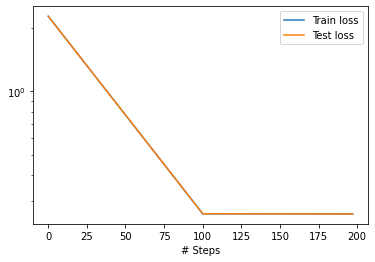

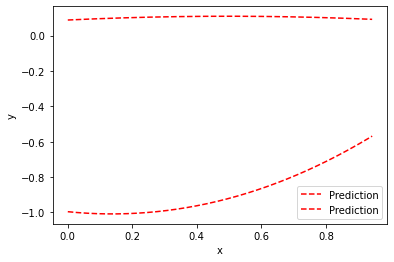

ic| mu*r0[0]/((r0[0]**2) + (r0[1]**2))**(3/2): -0.9960792012755969
    dy_dxx: array([[1.3661227]], dtype=float32)


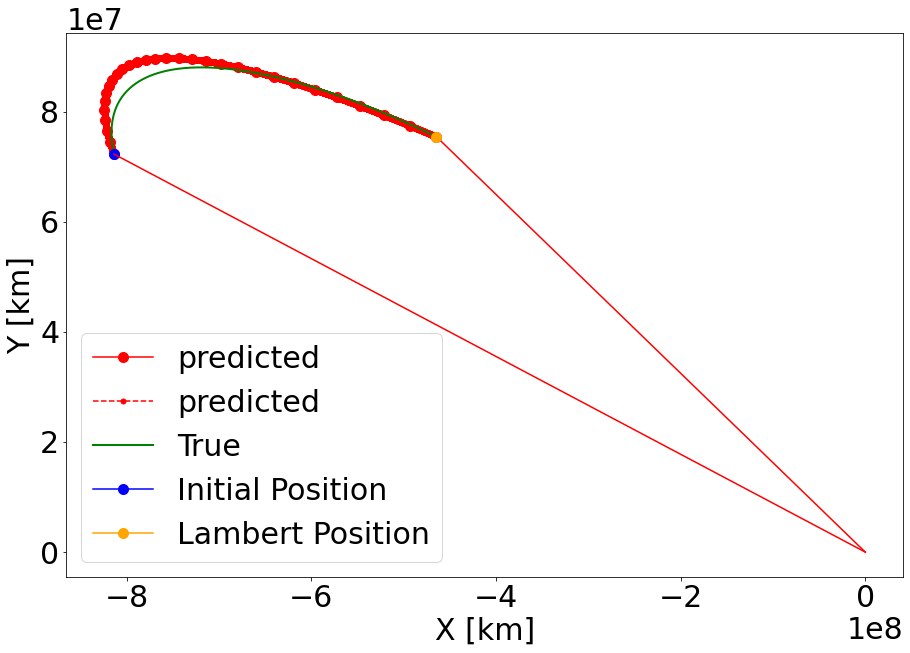

ic| upred[-1,1]/1e5: 754243.91168
ic| TrueStates[-1,:]*nc: array([-3.79571570e+23,  1.26387065e+16,  6.16316401e+22, -1.03441484e+15,
                                 0.00000000e+00,  0.00000000e+00])
ic| _rf: array([-4.64517167e+11,  7.54243919e+10])


array([-4.64517167e+11,  7.54243919e+10])

In [211]:
import matplotlib.pyplot as plt

plot_trajec = 0

ax = dde.saveplot(losshistory, train_state, issave=False, isplot=True)
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)

## Last Model
ax.plot(upred[:,0]/1000, upred[:,1]/1000, label = 'predicted',color='red', marker='o', markersize=10)
ax.ticklabel_format(useOffset=False)

## Best Model

X_train, y_train = train_state.X_train, train_state.y_train
X_test, y_test, best_y, best_ystd = train_state.X_test, train_state.y_test, train_state.best_y, train_state.best_ystd
idx = np.argsort(X_test[:, 0])
X = X_test[idx, 0]
Pred_x = best_y[idx, 0]
Pred_y = best_y[idx, 1]
# ic(Pred_y)
plt.plot(Pred_x*nc/1000, Pred_y*nc/1000, "--r", label = 'predicted',color='red', marker='o', markersize=5)

## Correct Solution
ax.set_xlabel('X [km]', fontsize=30)
ax.set_ylabel('Y [km]', fontsize=30)
ax.tick_params(labelsize=40)
ax.legend(fontsize=40)

# ax.set_ylim([-2,2]
# ax.set_xlim([-2,2])
def dydx1(x, y):
    return dde.grad.jacobian(y, x, i=0, j=0)
dy_dx1 = model.predict(np.array([[0]]), operator=dydx1)

def dydxx1(x, y):
    return dde.grad.hessian(y, x, component=0)

dy_dxx = model.predict(np.array([[0]]), operator=dydxx1)
ic(mu*r0[0]/((r0[0]**2) + (r0[1]**2))**(3/2) , dy_dxx)

# ic(best_y.shape)

TrueStates = plot3D_grav(_r0, v0, ub*tnc, mode='SUN', ax=ax, uf=_rf)
ic(upred[-1,1]/1e5)
ic(TrueStates[-1,:]*nc)
ic(_rf)

# ax.view_init(90,0)
# plt.show()

# ax = pk.orbit_plots.plot_lambert(lamsol_list, N=60, sol=0, units=pk.AU, legend=False, axes=None, alpha=1.)  
# ax.view_init(90,0)

In [190]:
def dydxx1(x, y):
    return dde.grad.hessian(y, x, component=0)

def dydxx2(x, y):
    return dde.grad.hessian(y, x, component=1)

upred2=upred/nc
dy_dxx1 = model.predict(tsample, operator=dydxx1)
dy_dx1 = model.predict(np.array(tsample), operator=dydx1)

dy_dxx2 = model.predict(np.array([[0]]), operator=dydxx2)[0][0]

print(dy_dxx1.T)
# print((norm(upred2, axis=1)))
print( mu*upred2[:,0]/(norm(upred2, axis=1)**3), '\n')

print(dy_dx1.T)
print(states[:,1].T/nc*tnc)

print(dy_dxx2)
print( mu*r0[1]/(norm(r0)**3))

[[1.3849368 1.3723214 1.3622408 1.3545035 1.348916  1.3452823 1.3434052
  1.3430889 1.3441403 1.346369  1.349591  1.3536247 1.3582973 1.3634415
  1.3688982 1.3745161 1.3801532 1.3856747 1.3909546 1.3958774 1.4003346
  1.404229  1.4074702 1.4099796 1.4116819 1.4125175 1.4124286 1.4113694
  1.4093003 1.4061881]]
[-0.9960792  -0.9846475  -0.97621757 -0.9706595  -0.96789026 -0.9678659
 -0.97058254 -0.9760741  -0.98441297 -0.9957112  -1.0101248  -1.0278568
 -1.049165   -1.0743691  -1.1038632  -1.1381279  -1.1777501  -1.2234457
 -1.2760928  -1.3367704  -1.4068149  -1.487891   -1.5820946  -1.6920863
 -1.8212854  -1.9741441  -2.156545   -2.3763871  -2.6444848  -2.9759645 ] 

[[-0.19038296 -0.1455484  -0.10108298 -0.05690652 -0.01294607  0.03086472
   0.07458639  0.11827305  0.16197214  0.20572504  0.24956706  0.29352757
   0.33763015  0.38189295  0.4263284   0.47094434  0.5157438   0.5607252
   0.6058824   0.65120584  0.6966822   0.74229467  0.78802305  0.8338458
   0.8797365   0.92566913  0.9